# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traceback
from tqdm.notebook import tnrange
from scipy.special import logit, expit
from PolicyGradientAgent import StochasticGradientAgent
from Environment import *

In [2]:
learning_rate_theta = 1e-4
learning_rate_wv = 1e-4
memory_size = 1024
batch_size = 1024
training_episodes = 900000
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
learning_std = False
fixed_std = 0.3
# Bucket parameters
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
prior_red_list = [3/4, 1/4]

agent = StochasticGradientAgent(feature_shape=[1, 3], learning_rate_theta=learning_rate_theta, 
                                learning_rate_wv=learning_rate_wv, 
                                memory_size= memory_size, batch_size=batch_size,
                                beta1=beta1, beta2=beta2, 
                                learning_std=learning_std, fixed_std=fixed_std)


reward_history_list = []

mean_weights_history_list = []
std_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []
r_ball_std_history_list = []
b_ball_std_history_list = []

r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []
grad_r_ball_std_history_list = []
grad_b_ball_std_history_list = []

grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []
grad_r_ball_v_std_history_list = []
grad_b_ball_v_std_history_list = []

grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []
grad_r_ball_adam_std_history_list = []
grad_b_ball_adam_std_history_list = []

grad_mean_history_list = []
mean_history_list = []
std_history_list = []
report_history_list = []

for t in tnrange(training_episodes):
    prior_red = np.random.choice(prior_red_list)
#     prior_red = np.random.uniform()
    bucket = Bucket(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
    pm = PredictionMarket(prior_red=prior_red)
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(logit(prior_red))
    h, mean, std = agent.report(x)
    pi = expit(h)
    report = [pi, 1 - pi]

    pm.report(report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    mean_weights_history_list.append(agent.theta_mean[0].tolist())
    std_weights_history_list.append(agent.theta_std[0].tolist())
    
    actual_pr_ru_S = 0
    expected_log_reward = 0
    max_expected_log_reward = 0
    regret = 0
    if signal == 'red':
        actual_pr_ru_S = analytical_best_report_ru_rs(pr_ru=prior_red, pr_rs_ru=pr_red_ball_red_bucket, pr_rs_bu=pr_red_ball_blue_bucket)
        expected_log_reward = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_S, estimated_pr_ru_rs=pi, pr_ru=prior_red)
        max_expected_log_reward = expected_log_reward_red_ball(actual_pr_ru_rs=actual_pr_ru_S, estimated_pr_ru_rs=actual_pr_ru_S, pr_ru=prior_red)
    else:
        actual_pr_ru_S = analytical_best_report_ru_bs(pr_ru=prior_red, pr_bs_ru=1-pr_red_ball_red_bucket, pr_bs_bu=1-pr_red_ball_blue_bucket)
        expected_log_reward = expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_S, estimated_pr_ru_bs=pi, pr_ru=prior_red)
        max_expected_log_reward = expected_log_reward_blue_ball(actual_pr_ru_bs=actual_pr_ru_S, estimated_pr_ru_bs=actual_pr_ru_S, pr_ru=prior_red)

    v = agent.store_experience(x, h, mean, std, R, t)
    
    reward_history_list.append([R, v, expected_log_reward, max_expected_log_reward, signal, prior_red])
    try:
        grad_mean, grad_std, v_dw_mean_corrected, v_dw_std_corrected, \
        s_dw_mean_corrected, s_dw_std_corrected = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)

    agent.learning_rate_decay(epoch=t, decay_rate=decay_rate)

    if signal == 'red':
        r_ball_pred_history_list.append(report[0])
        r_ball_mean_history_list.append(mean)
        r_ball_std_history_list.append(std)
       
    else:
        b_ball_pred_history_list.append(report[0])
        b_ball_mean_history_list.append(mean)
        b_ball_std_history_list.append(std)
    
    report_history_list.append([report[0], signal])
    mean_history_list.append([mean, signal])
    std_history_list.append([std, signal])
    grad_mean_history_list.append(grad_mean[0, :])
    
    grad_r_ball_mean_history_list.append(grad_mean[0, 0])
    grad_r_ball_std_history_list.append(grad_std[0, 0])
    ##########
    grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 0])
    grad_r_ball_v_std_history_list.append(v_dw_std_corrected[0, 0])
    grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 0])
    grad_r_ball_adam_std_history_list.append(s_dw_std_corrected[0, 0])
    ##################################################################
    grad_b_ball_mean_history_list.append(grad_mean[0, 1])
    grad_b_ball_std_history_list.append(grad_std[0, 1])
    ##########
    grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0, 1])
    grad_b_ball_v_std_history_list.append(v_dw_std_corrected[0, 1])
    grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0, 1])
    grad_b_ball_adam_std_history_list.append(s_dw_std_corrected[0, 1])

  0%|          | 0/900000 [00:00<?, ?it/s]

learning_rate_theta= 0.0001  learning_rate_wv= 0.0001
memory_size= 1024  standard deviation= 0.3
Updating weights with regular algorithm.


In [3]:
reward_history_df = pd.DataFrame(reward_history_list, columns=['actual_reward', 'estimated_reward', 'expected_reward', 'max_expected_reward','signal', 'prior_red'])

mean_weights_history_df = pd.DataFrame(mean_weights_history_list, columns=['red_weight', 'blue_weight', 'prior_weight'])
std_weights_history = np.array(std_weights_history_list)

grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)
grad_r_ball_std_history = np.array(grad_r_ball_std_history_list)
grad_b_ball_std_history = np.array(grad_b_ball_std_history_list)

grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)
grad_r_ball_v_std_history = np.array(grad_r_ball_v_std_history_list)
grad_b_ball_v_std_history = np.array(grad_b_ball_v_std_history_list)

grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)
grad_r_ball_adam_std_history = np.array(grad_r_ball_adam_std_history_list)
grad_b_ball_adam_std_history = np.array(grad_b_ball_adam_std_history_list)

grad_mean_history_df = pd.DataFrame(grad_mean_history_list, columns=['red_ball', 'blue_ball', 'prior'])
report_history_df = pd.DataFrame(report_history_list, columns=['report', 'signal'])
mean_history_df = pd.DataFrame(mean_history_list, columns=['mean', 'signal'])
std_history_df = pd.DataFrame(std_history_list, columns=['std', 'signal'])

In [4]:
std

0.3

Text(0.5, 0.98, 'Actual Rewards and Average')

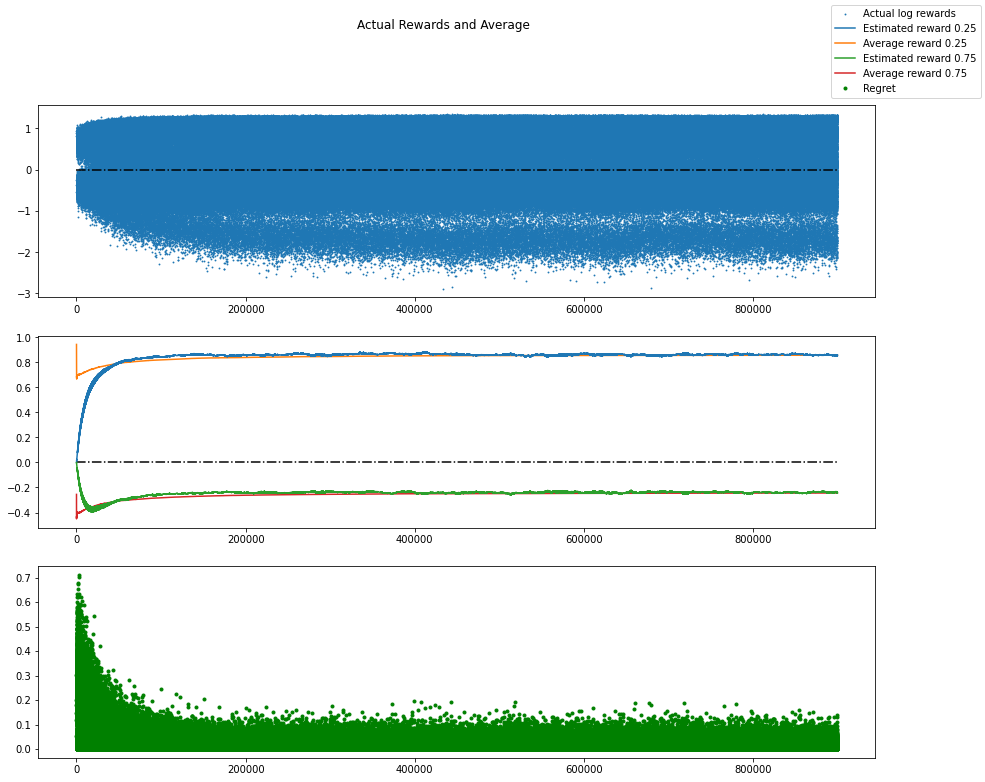

In [8]:
fig, axs = plt.subplots(3, figsize=(15, 12))
axs[0].scatter(x=reward_history_df.index, y=reward_history_df['actual_reward'],label = 'Actual log rewards', marker='.', s=3)

axs[2].plot(reward_history_df['max_expected_reward'] - reward_history_df['expected_reward'], 'g.',label='Regret')
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history_df.shape[0] , colors='black', linestyles='dashdot')
for signal, df in reward_history_df.reset_index().groupby('prior_red'):
    axs[1].plot(df['estimated_reward'], label='Estimated reward ' + str(signal))
    axs[1].plot(df['actual_reward'].expanding().mean(),zorder= -99, label = 'Average reward ' + str(signal))
fig.legend()
fig.suptitle('Actual Rewards and Average')

Text(0.5, 1.0, 'Report')

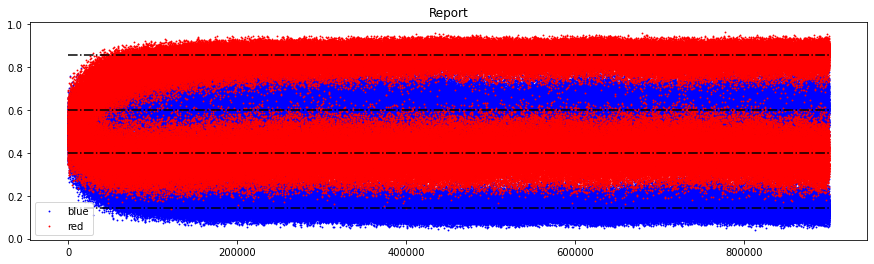

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in report_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=df['report'], label=signal, marker='.', c=signal, s=3, zorder=-99)
for prior_red in prior_red_list:
    plt.hlines(
        y=analytical_best_report_ru_rs(
            pr_ru=prior_red, 
            pr_rs_ru=pr_red_ball_red_bucket, 
            pr_rs_bu=pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(report_history_df), colors='black', linestyles='dashdot', zorder=-98)

    plt.hlines(
        y=analytical_best_report_ru_bs(
            pr_ru=prior_red, 
            pr_bs_ru=1-pr_red_ball_red_bucket, 
            pr_bs_bu=1-pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(report_history_df), colors='black', linestyles='dashdot', zorder=-98)
ax.legend(loc='lower left')
plt.title('Report')

In [10]:
grad_mean_successive_dot = np.sum(grad_mean_history_df.values * np.roll(grad_mean_history_df.values, 1, axis=0), axis=1)[1:]
grad_mean_successive_dot

array([7.07574158e+01, 3.91724483e+01, 1.89027517e+01, ...,
       3.06410174e-02, 3.06263606e-02, 2.95860301e-02])

In [11]:
(mark_index, ) = np.where(grad_mean_successive_dot < 0)
mark_index

array([124772, 124836, 124918, 143884, 147699, 148806, 148816, 238222,
       238237, 238268, 244306, 264772, 264832, 266663, 339444, 352600,
       364570, 369791, 393800, 445766, 447014, 447328, 447332, 447438,
       457160, 458408, 458430, 515050, 515062, 557600, 573085, 573131,
       596970, 625072, 629091, 629548, 705035, 712948, 712966, 712979,
       740981, 740987, 741094, 752509, 777482, 809326, 823058, 827264,
       860896, 872167])

In [12]:
def phase_change_coordinates(mark_index, df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    coord_list = []
    prev_x = 0
    for x in mark_index:
        if x > 50:
            if x > prev_x + 1000:
                coord_list.append((x, df.select_dtypes(include=numerics).loc[x, :].max()))
                prev_x = x
    return coord_list

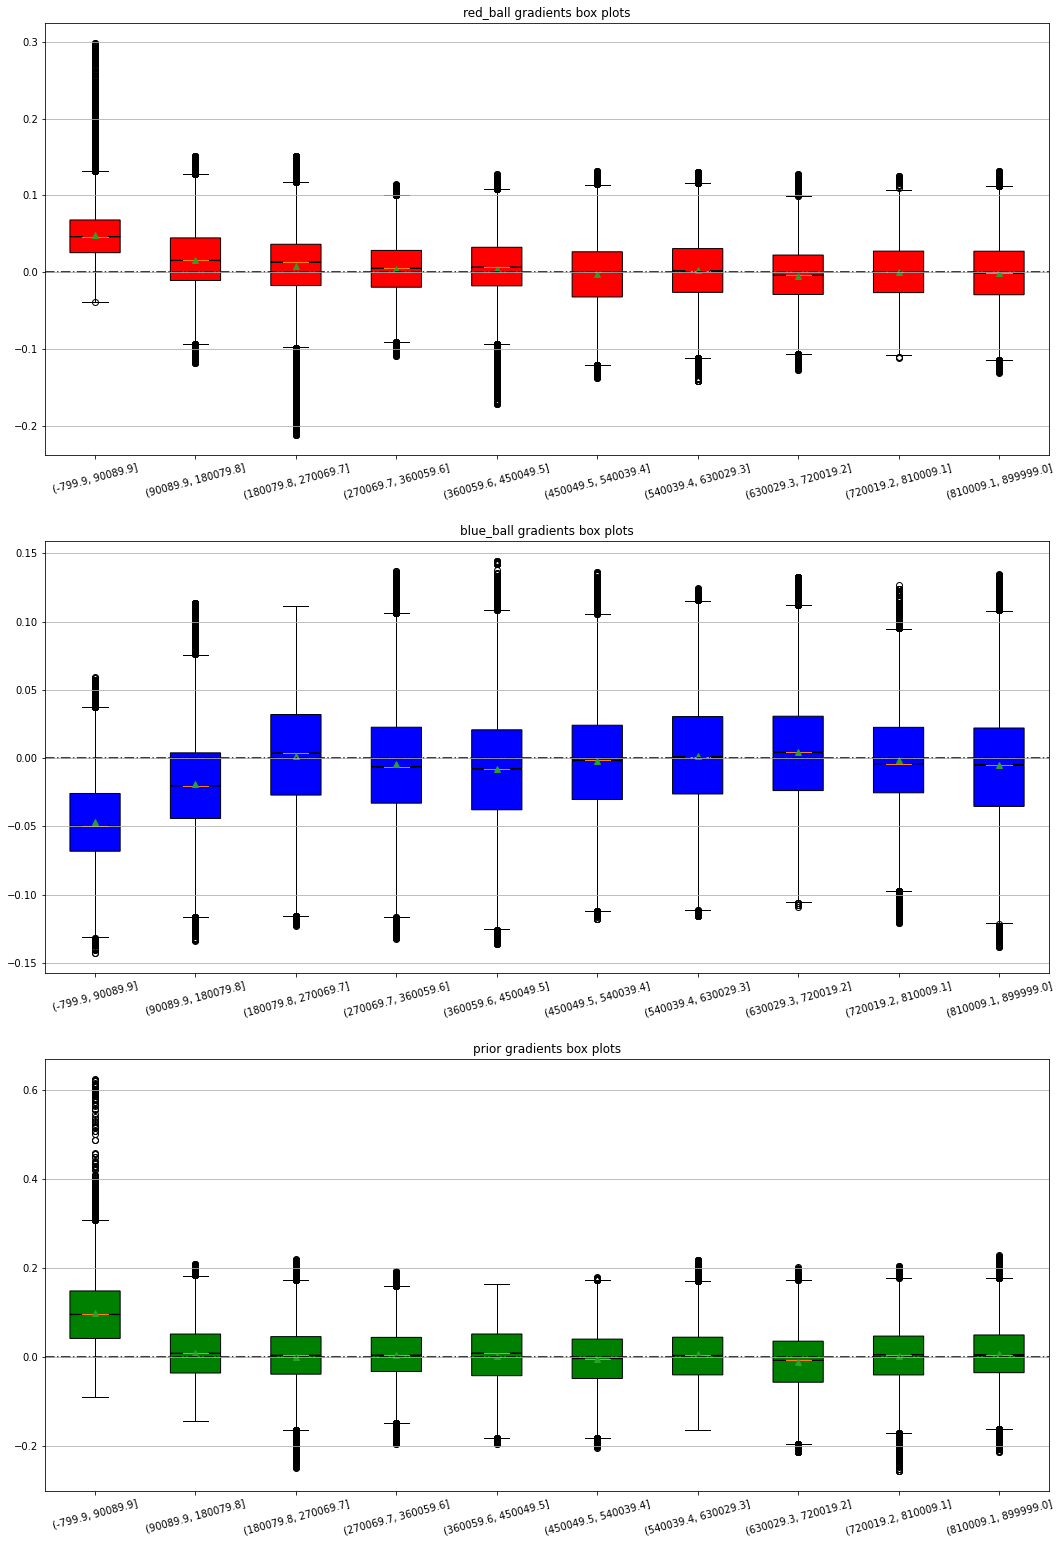

In [21]:
fig, axs = plt.subplots(3, figsize=(18, 9*3))
gradients_box_subplot(df=grad_mean_history_df.iloc[100:, :], column_list=grad_mean_history_df.columns, colour_list=['red', 'blue', 'green'], axs=axs)
# fig.suptitle("State-Action Estimated Value Gradients")

In [ ]:
grad_mean_history_df.iloc[-50000:, :].describe()

In [ ]:
from scipy.ndimage import uniform_filter1d

In [ ]:
moving_size = 1000
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_mean_successive_dot[100:], zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black', zorder=-99)
axs[0].set_title('Successive gradients dot product')
axs[1].plot(uniform_filter1d(grad_mean_successive_dot[100:], size=moving_size), zorder=-100)
axs[1].hlines(y=0, xmin=0, xmax=len(grad_mean_successive_dot), linestyles='dashdot', color='black', zorder=-99)
axs[1].set_title('Successive gradients dot product size %i moving average'%moving_size)

In [ ]:
import matplotlib.lines as mlines

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
for signal, df in mean_history_df.reset_index().groupby('signal'):
    ax.scatter(x=df['index'], y=expit(df['mean']), label=signal, marker='.', c=signal, alpha=0.6, s=0.1)
for prior_red in prior_red_list:
    plt.hlines(
        y=analytical_best_report_ru_rs(
            pr_ru=prior_red, 
            pr_rs_ru=pr_red_ball_red_bucket, 
            pr_rs_bu=pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='red', linestyles='dashdot')

    plt.hlines(
        y=analytical_best_report_ru_bs(
            pr_ru=prior_red, 
            pr_bs_ru=1-pr_red_ball_red_bucket, 
            pr_bs_bu=1-pr_red_ball_blue_bucket
        ), xmin=0, xmax=len(mean_history_df), colors='blue', linestyles='dashdot')
red_line = mlines.Line2D([], [], color='red', label='red signal')
blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
# for coord in phase_change_coordinates(mark_index, mean_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
ax.legend(handles=[red_line, blue_line], loc='lower left')
plt.title('Mean')

In [ ]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history_df.iloc[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history_df.iloc[1:, 1], label='Blue weight')
plt.plot(mean_weights_history_df.iloc[1:, 2], 'g', label='Prior weight')
plt.hlines(y=logit(pr_red_ball_red_bucket), xmin=0, xmax=len(mean_weights_history_df), colors='red', linestyles='dashdot')
plt.annotate('%.3f'%logit(pr_red_ball_red_bucket), xy=(len(mean_weights_history_df)/2, logit(pr_red_ball_red_bucket)), xytext=(len(mean_weights_history_df)/2, np.log(2)/2), arrowprops=dict(arrowstyle="->"))
plt.hlines(y=logit(pr_red_ball_blue_bucket), xmin=0, xmax=len(mean_weights_history_df) , colors='blue', linestyles='dashdot')
plt.annotate('%.3f'%logit(pr_red_ball_blue_bucket), xy=(len(mean_weights_history_df)/2, logit(pr_red_ball_blue_bucket)), xytext=(len(mean_weights_history_df)/2, np.log(1/2)/2), arrowprops=dict(arrowstyle="->"))
plt.hlines(y=1, xmin=0, xmax=len(mean_weights_history_df) , colors='green', linestyles='dashdot')
# for coord in phase_change_coordinates(mark_index, mean_weights_history_df):
#     plt.annotate('change', xy=coord, xytext=(coord[0], 0.1), arrowprops=dict(arrowstyle="->"))
plt.legend()
plt.title('Weights for Mean')

In [ ]:
def pd_table_to_fig(data, title, footer='', fig_background_color='skyblue', fig_border='steelblue'):
    rcolors = plt.cm.BuPu(np.full(len(data.index), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(data.columns), 0.1))
    # Create the figure. Setting a small pad on tight_layout
    # seems to better regulate white space. Sometimes experimenting
    # with an explicit figsize here can produce better outcome.
    plt.figure(linewidth=2,
               edgecolor=fig_border,
               facecolor=fig_background_color,
               tight_layout={'pad':1},
               figsize=(10,6)
              )
    # Hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    the_table = pd.plotting.table(ax=ax, data=data,
                                  rowColours=rcolors,
                                  rowLoc='right',
                                  colColours=ccolors,
                                  loc='center')
    the_table.scale(1, 1.5)
    # Hide axes border
    plt.box(on=None)
    # Add title
    plt.suptitle(title)
    # Add footer
    plt.figtext(0.95, 0.05, footer, horizontalalignment='right', size=6, weight='light')
    # Force the figure to update, so backends center objects correctly within the figure.
    # Without plt.draw() here, the title will center on the axes and not the figure.
    plt.draw()
    # Create image. plt.savefig ignores figure edge and face colors, so map them.
    fig = plt.gcf()
    

query_index = mean_weights_history_df.shape[0]//3
pd_table_to_fig(data=mean_weights_history_df.iloc[-query_index:, :].describe(), title='Mean Weights Summary', footer='')

In [ ]:
mean_weights_history_df.iloc[-query_index:, :].describe()

In [ ]:
if learning_std:
    min_std = std_history_df['std'].min()
    fig, ax = plt.subplots(figsize=(15, 4))
    for signal, df in std_history_df.reset_index().groupby('signal'):
        ax.scatter(x=df['index'], y=df['std'], label=signal, marker='.', c=signal, s=0.1)
    plt.hlines(y=0, xmin=0, xmax=len(std_history_df) , colors='black', linestyles='dashdot')
    plt.hlines(y=min_std, xmin=0, xmax=len(std_history_df) , colors='black', linestyles='dashdot', label=str(min_std))
    red_line = mlines.Line2D([], [], color='red', label='red signal')
    blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
    ax.legend(handles=[red_line, blue_line])
    plt.title('Standard Diviation')

In [ ]:
if learning_std:
    fig = plt.figure(figsize=(15, 4))
    plt.plot(std_weights_history[:, 0], 'r', label='Red weight')
    plt.plot(std_weights_history[:, 1], label='Blue weight')
    plt.plot(std_weights_history[:, 2], 'g', label='Prior weight')
    plt.legend()
    plt.title('Weights for standard diviation')

In [ ]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(no_outlier_array(grad_r_ball_mean_history), 'r.', label = 'red ball', zorder=-100)
axs[1].plot(no_outlier_array(grad_b_ball_mean_history),'b.',label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

In [ ]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(no_outlier_array(grad_r_ball_v_mean_history), 'r.', label = 'red ball', zorder=-100)
axs[1].plot(no_outlier_array(grad_b_ball_v_mean_history), 'b.',label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

In [ ]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(no_outlier_array(grad_r_ball_adam_mean_history), 'r.', label = 'red ball', zorder=-100)
axs[1].plot(no_outlier_array(grad_b_ball_adam_mean_history), 'b.',label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

In [ ]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(no_outlier_array(grad_r_ball_mean_history[:, 2]), 'r.', label = 'red ball', zorder = -100)
# axs[1].plot(no_outlier_array(grad_b_ball_mean_history[:, 2]), 'b.',label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient')

In [ ]:
# fig, axs = plt.subplots(2, figsize=(15, 8))
# axs[0].plot(no_outlier_array(grad_r_ball_v_mean_history[:, 2]), 'r.', label = 'red ball', zorder = -100)
# axs[1].plot(no_outlier_array(grad_b_ball_v_mean_history[:, 2]),'b.',label = 'blue ball', zorder = -100)
# axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
# fig.legend()
# fig.suptitle('Prior Mean Gradient (Momentum)')

In [ ]:
if learning_std:
    fig, axs = plt.subplots(2, figsize=(15, 8))
    axs[0].plot(no_outlier_array(grad_r_ball_std_history), 'r.', label = 'red ball', zorder = -100)
    axs[1].plot(no_outlier_array(grad_b_ball_std_history), 'b.',label = 'blue ball', zorder = -100)
    axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_std_history.shape[0], colors='black', linestyles='dashdot')
    axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_std_history.shape[0], colors='black', linestyles='dashdot')
    fig.legend()
    fig.suptitle('Signal Standard Diviation Gradient')

In [ ]:
if learning_std:
    fig, axs = plt.subplots(2, figsize=(15, 8))
    axs[0].plot(no_outlier_array(grad_r_ball_v_std_history), 'r.', label = 'red ball', zorder = -100)
    axs[1].plot(no_outlier_array(grad_b_ball_v_std_history), 'b.',label = 'blue ball', zorder = -100)
    axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    fig.legend()
    fig.suptitle('Signal Standard Diviation Gradient (Momentum)')

In [ ]:
if learning_std:
    fig, axs = plt.subplots(2, figsize=(15, 8))
    axs[0].plot(no_outlier_array(grad_r_ball_adam_std_history), 'r.', label = 'red ball', zorder=-100)
    axs[1].plot(no_outlier_array(grad_b_ball_adam_std_history), 'b.',label = 'blue ball', zorder=-100)
    axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
    fig.legend()
    fig.suptitle('Signal Standard Diviation Gradient (Adam)')